In [115]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import smogn
import seaborn as sns

In [171]:
seed = 2013

In [172]:
df = pd.read_excel("../spring21_data/fa_stats_v3.xlsx")
df = df.select_dtypes(exclude=['object'])
df.drop(columns=["Unnamed: 0", "Minutes", "salary", "clean_season", "age", "end season_y", "season_end"], inplace=True)

X = df.drop(columns=["cap_space_usage"])
y = df["cap_space_usage"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)
both = pd.concat([X_train, y_train], axis=1).reset_index().drop(columns=["index"])
smote_data_high = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'high',
                           rel_thres = 0.85,
                           k = 9,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'extreme')
smote_data_mid = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'high',
                           rel_thres = 0.25,
                           k = 9,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'extreme')
smote_data_low = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'both',
                           rel_thres = 0.001,
                           k = 9,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'extreme')
smote_data = pd.concat([smote_data_high, smote_data_mid, smote_data_low], ignore_index=True).drop_duplicates()
sm = smote_data.sample(frac=1) ## make sure to shuffle the rows otherwise the cross validation will be scuffed
y = sm[['cap_space_usage']]
X = sm.drop(columns=['cap_space_usage'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=seed)

# scale the numerical features only (this leaves out the dummy features from earlier)

from sklearn.feature_selection import SelectKBest, f_regression
select = SelectKBest(f_regression, k=20)

best_features = select.fit_transform(X, y)
feature_scores = pd.concat([pd.Series(X.columns), pd.Series(select.scores_)], axis=1)
feature_scores.columns = ["features", "score"]
features = list(feature_scores.sort_values(by=["score"], ascending=False).head(40)['features'])

X_train = X_train[features]
X_test = X_test[features]
X_val = X_val[features]

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_squared_log_error
def evaluate(y_pred, y_test):
    """ Prints out the evaluation metrics of the experiment
        parameters:
            y_pred
                DataFrame or array-like, the predictions
            y_test
                DataFrame or array-like, the actual y-values
                
            these two parameters must have the same dimensions
    """
    print("r^2: ", r2_score(y_test, y_pred))
    print("mse: ", mean_squared_error(y_test, y_pred))
    print("variance_score: ", explained_variance_score(y_test, y_pred))
    print("mse-log: ", mean_squared_log_error(y_test, y_pred))
    
def run(model, model_name, x_train, x_val):
    """ Fits the model and prints out results from calling evaluate on the training and validation set
        parameters:
            model
                the unfitted model, from sklearn (has to have a fit and predict method)
            model_name
                String, the name of the model
            x_train
                DataFrame, the training set
            x_val
                DataFrame, the validation set
                
        returns:
            nothing
        
    """
    model = model.fit(x_train, y_train)
    y_pred = np.clip(model.predict(x_train), 0, 1000) # since negative results are meaningless
    
    print("[{0}] These are the results for the training set.".format(model_name))
    
    evaluate(y_pred, y_train)
    print("--------------------------------------")
    
    print("[{0}] These are the results for the validation set.".format(model_name))
    y_pred = np.clip(model.predict(x_val), 0, 1000) # since negative results are meaningless
    
    evaluate(y_pred, y_val)
    
    print("_____________________________________________")

r_index: 100%|##########| 15/15 [00:00<00:00, 305.84it/s]
D:\Users\chengmingliu\Anaconda3\envs\nba-model\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


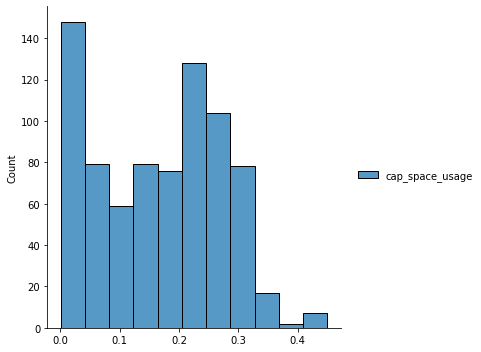

In [173]:
sns.displot(y)

In [117]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in tree
n_estimators = range(25, 450, 15)

# Maximum number of levels in tree
max_depth = range(3, 10, 2)

min_child_weight = range(1,7)
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_child_weight': min_child_weight,
               'gamma':[i/10.0 for i in range(0,20)],
               'colsample_bytree': [i/100.0 for i in range(60, 90, 5)],
               'learning_rate': [i/100.0 for i in range(5, 20, 5)],
               'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}

In [174]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgb = XGBRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 300, cv = 7, verbose=3, random_state=seed, n_jobs = -1)
# Fit the random search model
xgb_random.fit(X_train, y_train)

Fitting 7 folds for each of 300 candidates, totalling 2100 fits


KeyboardInterrupt: 

In [138]:
xgb_random.best_params_

{'reg_alpha': 1e-05,
 'n_estimators': 370,
 'min_child_weight': 3,
 'max_depth': 9,
 'learning_rate': 0.05,
 'gamma': 0.0,
 'colsample_bytree': 0.8}

In [ ]:
reg_alpha= 1e-05,
 n_estimators= 370,
 min_child_weight= 3,
 max_depth= 9,
 learning_rate= 0.05,
 gamma= 0.0,
 colsample_bytree= 0.8

In [76]:
from sklearn.model_selection import GridSearchCV

In [77]:
xgb = XGBRegressor(reg_alpha= 0.1,
 n_estimators= 130,
 min_child_weight= 4,
 max_depth= 5,
 learning_rate= 0.15,
 gamma= 0.0,
 colsample_bytree= 0.7,
scale_pos_weight = 1)

grid = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch = GridSearchCV(estimator = xgb, 
                       param_grid = grid, n_jobs=-1, cv=5)
gsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.7,
                                    gamma=0.0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=3,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=85, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=1, subsample=None,
                                    tree_method=None, validate_parameters=None,


In [78]:
gsearch.best_params_

{'reg_alpha': 1e-05}

In [175]:
xgb = XGBRegressor(reg_alpha= 1e-05,
 n_estimators= 370,
 min_child_weight= 3,
 max_depth= 9,
 learning_rate= 0.05,
 gamma= 0.0,
 colsample_bytree= 0.8)

run(xgb, "XGB", X_train, X_val)

[XGB] These are the results for the training set.
r^2:  0.9999426993110806
mse:  6.30474514464779e-07
variance_score:  0.9999426993304197
mse-log:  4.6101838576406485e-07
--------------------------------------
[XGB] These are the results for the validation set.
r^2:  0.8686033716325174
mse:  0.0015273165057489424
variance_score:  0.8689777226071521
mse-log:  0.0011252606688407715
_____________________________________________


In [176]:
evaluate(xgb.predict(X_test), y_test)

r^2:  0.8295635393643167
mse:  0.0014866386745883188
variance_score:  0.8313024845783531
mse-log:  0.0011435842725534193


In [177]:
data = pd.read_excel("../spring21_data/fa_stats_v3.xlsx")

In [178]:
test_index = X_test.index
test_data = data.iloc[test_index][['clean_season','Player','MPG', 'attempted_field_goals', 'minutes_played', 'WS', 'Wins Added', 'poss','cap_space_usage']]
results = pd.concat([test_data, pd.DataFrame(index=test_index, data=xgb.predict(X_test))], axis=1)

In [179]:
results

,clean_season,Player,MPG,attempted_field_goals,minutes_played,WS,Wins Added,poss,cap_space_usage,0
362,2019,Jabari Parker,26.9,11.897436,26.717949,1.4,1.662402,3694,0.059557,0.064579
274,2018,Raul Neto,12.1,3.682927,12.146341,0.9,0.416141,1201,0.021106,0.025246
232,2018,Wayne Ellington,26.5,9.090909,26.506494,4.5,2.589305,4309,0.061550,0.100303
373,2019,Brad Wanamaker,9.5,2.916667,9.527778,1.0,0.451722,775,0.013246,0.014579
107,2016,Thomas Robinson,12.9,4.098592,12.915493,0.6,0.655749,1879,0.011163,0.022567
23,2016,Trevor Booker,20.7,4.911392,20.658228,4.3,2.731892,3203,0.098255,0.074470
231,2018,Fred VanVleet,20.0,7.171053,20.000000,4.7,4.728443,3316,0.088349,0.076572
111,2016,Alan Anderson,14.8,4.538462,14.769231,0.3,0.339625,403,0.013973,0.034777
394,2019,Isaiah Thomas,15.1,8.250000,15.083333,-0.3,0.117090,403,0.021258,0.034493
124,2017,Jeff Teague,32.4,11.085366,32.402439,8.1,6.991121,5710,0.191739,0.251240
